In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/GoogleDrive', force_remount=True)

Mounted at /GoogleDrive


#Predictions Deep Dive
First the predicted and true values were saved to data frames

In [ ]:
checkpoint = torch.load("/GoogleDrive/My Drive/Colab Notebooks/datasets/runs/modelbesttaxifull_30epochs_128.pt")#,map_location=torch.device('cpu'))
#print(checkpoint["epoch"])

model1 = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
model1.load_state_dict(checkpoint['model_state_dict'])

rms,mae,quant, y_pred, y_truth = eval(model1, device, test_dataloader, 'Test')

print(y_pred.shape)
print(y_truth.shape)

new_y_pred = y_pred.view(-1)
new_y_truth = y_truth.view(-1)

print(new_y_pred.shape)
print(new_y_truth.shape)

array1 = new_y_pred.numpy()
array2 = new_y_truth.numpy()

# Create a DataFrame
df = pd.DataFrame({
    'y_pred': array1,
    'y_truth': array2,
})

# Save DataFrame to .csv file
df.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/results_taxi.csv', index=False)

In [ ]:
from datetime import datetime, timedelta
df = pd.read_csv("")

minus = len(df["y_pred"]) - 61991520#37368720
df = df[:-minus]

t = []
day = 1440
start = 120
for k in range(426):
  for l in range(85):
    for j in range(428): #258
      for i in range(4):
        t.append(k * day + start + (i + l) * 15)

print(len(t))

start_date = datetime(2019, 1, 1)
t_dates = [start_date + timedelta(minutes=minutes) for minutes in t]

df["timestamp"] = t_dates

df = df[df["y_truth"] >= 0.5]
df['diff'] = df['y_truth'] - df['y_pred']
df['abs_diff_percent'] = abs((df['y_truth'] - df['y_pred']) / df['y_truth']) * 100
df.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/results_bike1.csv')

In [ ]:
import datetime as dt

df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays1.csv', header = None)

df = df[-40896:]


t = [i * 15 for i in range(96*426)]

weekends = [0,0,0,0,1,1,0] * 60 + [0,0,0,0,1,1]
weekends = [value for value in weekends for _ in range(96)]

df = df.rename(columns={0: 'Holiday'})

df["Weekend"] = weekends

start_date = datetime(2019, 1, 1)
t_dates = [start_date + timedelta(minutes=minutes) for minutes in t]

df["timestamp"] = pd.to_datetime(t_dates)

df.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/timeanalysis.csv')

In [ ]:
import datetime as dt


df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/chicago1.csv')
df2 = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/chicago2.csv')

weather = pd.concat([df,df2],ignore_index=True)

weather = weather[-10224:]

weather_full = weather.loc[weather.index.repeat(4)].reset_index(drop=True)

start_date = datetime(2019, 1, 1)
t_dates = [start_date + timedelta(minutes=minutes) for minutes in t]

weather_full["timestamp"] = pd.to_datetime(t_dates)

weather_full = weather_full.drop('datetime', axis=1)

weather_full["Snow"] = weather_full['conditions'].apply(lambda x: 1 if 'snow' in x.lower() else 0)
weather_full["Rain"] = weather_full['conditions'].apply(lambda x: 1 if 'rain' in x.lower() else 0)
weather_full["Clear"] = weather_full['conditions'].apply(lambda x: 1 if 'clear' in x.lower() or 'cloudy' in x.lower() else 0)
weather_full["Cloudy"] = weather_full['conditions'].apply(lambda x: 1 if 'overcast' in x.lower()  else 0)

weather_full = weather_full.drop('conditions', axis=1)

weather_full.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/weatheranalysis.csv')

In [ ]:
w = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/weatheranalysis.csv')
t = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/timeanalysis.csv')
b = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/results_bike1.csv')


In [ ]:
w = w.drop(w.columns[0], axis=1)
t = t.drop(t.columns[0], axis=1)
b = b.drop(b.columns[0], axis=1)

w["timestamp"] = pd.to_datetime(w["timestamp"])
t["timestamp"] = pd.to_datetime(t["timestamp"])
b["timestamp"] = pd.to_datetime(b["timestamp"])

Join the three tables to have one big table

In [ ]:
test = b.merge(w, on='timestamp', how='left')
test = test.merge(t, on='timestamp', how='left')

In [ ]:
print(test[test["abs_diff_percent"] == test["abs_diff_percent"].max()])

            y_pred  y_truth           timestamp       diff  abs_diff_percent  \
3540272  32.340557      1.0 2019-07-22 13:15:00 -31.340557         3134.0557   

         temp  windspeed  Snow  Rain  Clear  Cloudy  Holiday  Weekend  
3540272  23.3       32.7     0     0      1       0        0        0  


Calculate the UPE for all entries

In [ ]:
def process_value(x):
    if x > 0:
        return x * 3
    else:
        return abs(x)

test['UPE'] = test['diff'].apply(process_value)


In [ ]:
test.head()

,y_pred,y_truth,timestamp,diff,abs_diff_percent,temp,windspeed,Snow,Rain,Clear,Cloudy,Holiday,Weekend,UPE
0,0.006532,2.0,2019-01-01 02:30:00,1.993468,99.673400,1.8,18.7,0,0,0,1,1,0,5.980404
1,0.002924,1.0,2019-01-01 02:30:00,0.997076,99.707575,1.8,18.7,0,0,0,1,1,0,2.991227
2,0.020669,1.0,2019-01-01 02:30:00,0.979331,97.933085,1.8,18.7,0,0,0,1,1,0,2.937993
3,0.010147,1.0,2019-01-01 02:15:00,0.989853,98.985261,1.8,18.7,0,0,0,1,1,0,2.969558
4,0.007020,1.0,2019-01-01 02:30:00,0.992980,99.297991,1.8,18.7,0,0,0,1,1,0,2.978940


Caculate the category of the demand (1 to 11)
* Taxi: 1-10 = 1; 10-20 = 2; ... ; 90-100 = 10; >100 = 11
* Bike: 1-5 = 1; 10-20 = 2; ... ; 45-50 = 10; >50 = 11

In [ ]:
def calculate_value(x):
    if x >= 50: #50, 100
        return 11
    else:
        return int(x / 5) + 1 #5, 10

test['cat'] = test['y_truth'].apply(calculate_value)


In [ ]:
test.head(200)

,y_pred,y_truth,timestamp,diff,abs_diff_percent,temp,windspeed,Snow,Rain,Clear,Cloudy,Holiday,Weekend,UPE,cat
0,0.006532,2.0,2019-01-01 02:30:00,1.993468,99.673400,1.8,18.7,0,0,0,1,1,0,5.980404,1
1,0.002924,1.0,2019-01-01 02:30:00,0.997076,99.707575,1.8,18.7,0,0,0,1,1,0,2.991227,1
2,0.020669,1.0,2019-01-01 02:30:00,0.979331,97.933085,1.8,18.7,0,0,0,1,1,0,2.937993,1
3,0.010147,1.0,2019-01-01 02:15:00,0.989853,98.985261,1.8,18.7,0,0,0,1,1,0,2.969558,1
4,0.007020,1.0,2019-01-01 02:30:00,0.992980,99.297991,1.8,18.7,0,0,0,1,1,0,2.978940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.003369,1.0,2019-01-01 06:00:00,0.996631,99.663131,-0.3,17.9,1,1,1,0,1,0,2.989894,1
196,-0.000022,1.0,2019-01-01 05:15:00,1.000022,100.002232,0.2,13.2,1,1,1,0,1,0,3.000067,1
197,0.009690,1.0,2019-01-01 05:45:00,0.990310,99.030997,0.2,13.2,1,1,1,0,1,0,2.970930,1
198,0.059692,1.0,2019-01-01 06:00:00,0.940308,94.030769,-0.3,17.9,1,1,1,0,1,0,2.820923,1


Add Categories for Wind, Temperature, Time of the Day, and Season

In [ ]:
def wind(x):
    if x < 15:
        return 1
    if x < 29:
        return 2
    if x < 43:
        return 3
    else:
      return 4

test['windcat'] = test['windspeed'].apply(wind)

In [ ]:
def temp(x):
    if x < 0:
        return 1
    if x < 15:
        return 2
    if x < 30:
        return 3
    else:
      return 4

test['tempcat'] = test['temp'].apply(temp)

In [ ]:
def get_time_of_day(date):
    """
    Get time of day category from datetime.

    Args:
        date (pd.Timestamp): Input date

    Returns:
        int: Time of day category (1: Morning, 2: Afternoon, 3: Evening, 4: Night)
    """
    hour = date.hour

    if 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    elif 18 <= hour < 24:
        return 3  # Evening
    else:  # 0 <= hour < 6
        return 4  # Night

    return 4

test['timecat'] = test['timestamp'].apply(get_time_of_day)

In [ ]:
def get_season(date):
    month, day = date.month, date.day

    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    elif month in [12, 1, 2]:
        if (month == 3 and day < 20) or (month == 12 and day >= 22):
            return 4  # Winter
        elif month == 12 or month < 3:
            return 4  # Winter
    return 1  # Default is Spring

test['season'] = test['timestamp'].apply(get_season)

In [ ]:
print(test[(test["Cloudy"] == 1) & (test["cat"] < 2)].mean())


y_pred               0.649927
y_truth              1.405400
diff                 0.755472
abs_diff_percent    71.604570
temp                 6.801587
windspeed           16.904182
Snow                 0.035183
Rain                 0.130922
Clear                0.000000
Cloudy               1.000000
Holiday              0.035786
Weekend              0.224923
UPE                  2.697610
cat                  1.000000
windcat              1.628630
tempcat              1.974906
timecat              1.881434
season               2.901879
dtype: float64


<ipython-input-27-d31c87570572>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(test[(test["Cloudy"] == 1) & (test["cat"] < 2)].mean())


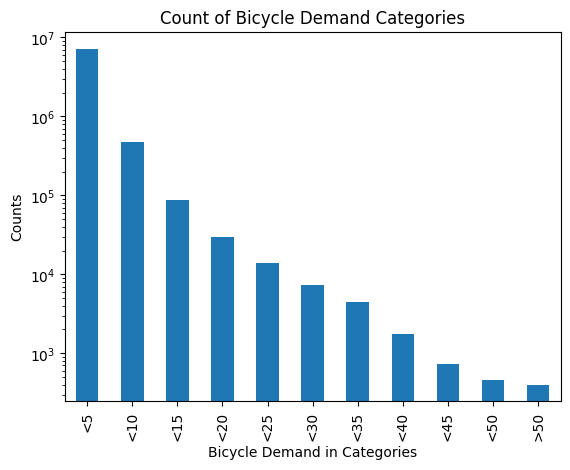

In [ ]:
import matplotlib.pyplot as plt
cat_counts = test["cat"].value_counts()

# Plotting the counts as bars
ax = cat_counts.plot.bar()
# Adding labels and title
plt.xlabel('Bicycle Demand in Categories')
plt.ylabel('Counts')
ax.set_yscale('log')
plt.title('Count of Bicycle Demand Categories')
#labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
plt.xticks(ticks=range(11), labels=labels)
# Displaying the plot
plt.show()

In [ ]:
mean_values = test.groupby(['Holiday', 'cat'])['UPE'].mean()
mean_values2 = test.groupby(['Weekend', 'cat'])['UPE'].mean()
mean_values3 = test.groupby(['Snow', 'cat'])['UPE'].mean()
mean_values4 = test.groupby(['Clear', 'cat'])['UPE'].mean()
mean_values5 = test.groupby(['Cloudy', 'cat'])['UPE'].mean()
mean_values6 = test.groupby(['Rain', 'cat'])['UPE'].mean()
mean_values7 = test.groupby(['windcat', 'cat'])['UPE'].mean()
mean_values8 = test.groupby(['tempcat', 'cat'])['UPE'].mean()
mean_values9 = test.groupby(['timecat', 'cat'])['UPE'].mean()
mean_values10 = test.groupby(['season', 'cat'])['UPE'].mean()




In [ ]:
print(mean_values2)

Weekend  cat
0        1        3.133041
         2        6.727801
         3       10.243600
         4       15.644332
         5       22.119091
         6       26.543276
         7       28.445182
         8       32.781798
         9       39.330580
         10      46.258611
         11      43.414784
1        1        3.127267
         2        7.747132
         3       11.952077
         4       18.218363
         5       29.269833
         6       33.691229
         7       44.753045
         8       65.446541
         9       71.633955
         10      99.601733
         11     116.403077
Name: UPE, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

def plotter(category, mean_values):
    # Convert the series to a DataFrame
    mean_values = mean_values.reset_index()

    # Reorder 'new_col' values so that '0' appears at the end
    ordered_categories = list(range(1, 12))
    mean_values['cat'] = pd.Categorical(mean_values['cat'], categories=ordered_categories, ordered=True)
    mean_values.sort_values('cat', inplace=True)

    # Separate the data by 'holiday'
    data_holiday_0 = mean_values[mean_values[category] == 0]
    data_holiday_1 = mean_values[mean_values[category] == 1]

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_holiday_0['cat'], data_holiday_0['UPE'], label='No '+ category)
    plt.plot(data_holiday_1['cat'], data_holiday_1['UPE'], label= category)

    # Set labels on x-axis
    labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
    #labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
    plt.xticks(ticks=range(1,12), labels=labels)

    plt.xlabel('Taxi Demand')
    plt.ylabel('Mean UPE')
    plt.title('Mean UPE by Amount of Taxi Demand and ' + category)
    plt.legend()
    plt.show()

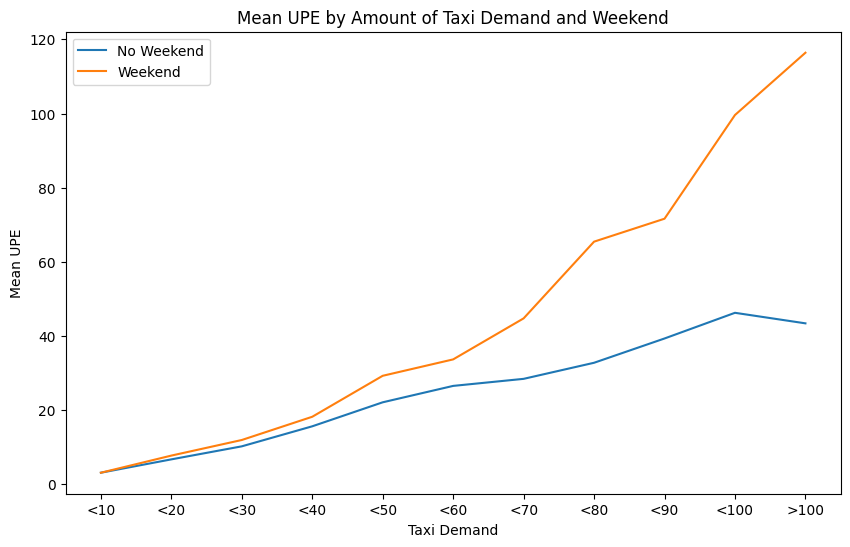

In [ ]:
plotter('Weekend', mean_values2)

In [ ]:
import matplotlib.pyplot as plt

def plotter2(category, mean_values1, mean_values2,mean_values3,mean_values4):
    # Convert the series to a DataFrame
    mean_values1 = mean_values1.reset_index()
    mean_values2 = mean_values2.reset_index()
    mean_values3 = mean_values3.reset_index()
    mean_values4 = mean_values4.reset_index()

    # Reorder 'new_col' values so that '0' appears at the end
    ordered_categories = list(range(1, 12))
    mean_values1['cat'] = pd.Categorical(mean_values1['cat'], categories=ordered_categories, ordered=True)
    mean_values1.sort_values('cat', inplace=True)

    mean_values2['cat'] = pd.Categorical(mean_values2['cat'], categories=ordered_categories, ordered=True)
    mean_values2.sort_values('cat', inplace=True)

    mean_values3['cat'] = pd.Categorical(mean_values3['cat'], categories=ordered_categories, ordered=True)
    mean_values3.sort_values('cat', inplace=True)

    mean_values4['cat'] = pd.Categorical(mean_values4['cat'], categories=ordered_categories, ordered=True)
    mean_values4.sort_values('cat', inplace=True)

    # Separate the data by 'holiday'
    data_holiday_0 = mean_values1[mean_values1['Snow'] == 1]
    data_holiday_1 = mean_values2[mean_values2['Clear'] == 1]
    data_holiday_2 = mean_values3[mean_values3['Cloudy'] == 1]
    data_holiday_3 = mean_values4[mean_values4['Rain'] == 1]

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_holiday_0['cat'], data_holiday_0['UPE'], label='Snow')
    plt.plot(data_holiday_1['cat'], data_holiday_1['UPE'], label= 'Clear')
    plt.plot(data_holiday_2['cat'], data_holiday_2['UPE'], label='Cloudy')
    plt.plot(data_holiday_3['cat'], data_holiday_3['UPE'], label= 'Rain')

    # Set labels on x-axis
    labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
    #labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
    plt.xticks(ticks=range(1,12), labels=labels)

    plt.xlabel('Taxi Demand')
    plt.ylabel('Mean UPE')
    plt.title('Mean UPE by Amount of Taxi Demand and ' + category)
    plt.legend()
    plt.show()

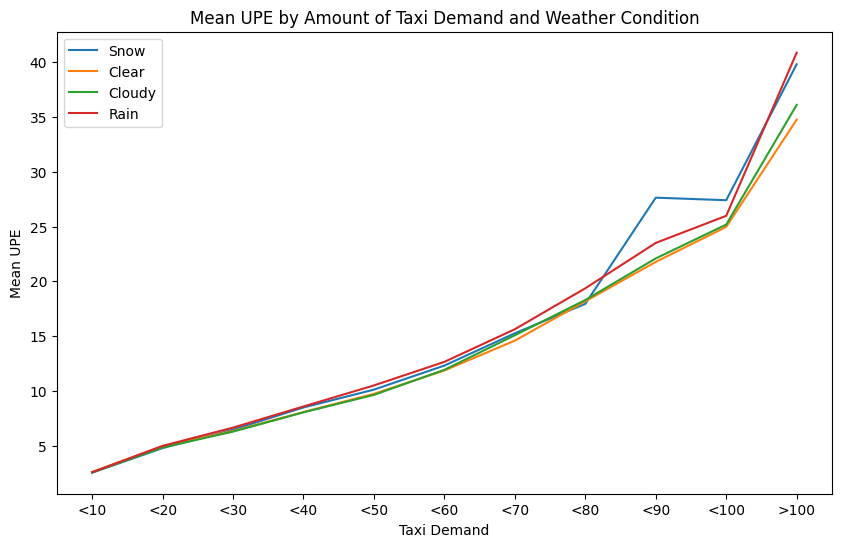

In [ ]:
plotter2('Weather Condition', mean_values3, mean_values4,mean_values5,mean_values6)

In [ ]:
print(test["temp"].min())

-29.7


In [ ]:
import matplotlib.pyplot as plt

def plotter3(category, mean_values1):
    # Convert the series to a DataFrame
    mean_values1 = mean_values1.reset_index()

    # Reorder 'new_col' values so that '0' appears at the end
    ordered_categories = list(range(1, 12))
    mean_values1['cat'] = pd.Categorical(mean_values1['cat'], categories=ordered_categories, ordered=True)
    mean_values1.sort_values('cat', inplace=True)



    # Separate the data by 'holiday'
    data_holiday_0 = mean_values1[mean_values1['windcat'] == 1]
    data_holiday_1 = mean_values1[mean_values1['windcat'] == 2]
    data_holiday_2 = mean_values1[mean_values1['windcat'] == 3]
    data_holiday_3 = mean_values1[mean_values1['windcat'] == 4]

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_holiday_0['cat'], data_holiday_0['UPE'], label='Light Breeze')
    plt.plot(data_holiday_1['cat'], data_holiday_1['UPE'], label= 'Moderate Breeze')
    plt.plot(data_holiday_2['cat'], data_holiday_2['UPE'], label='Strong Breeze')
    plt.plot(data_holiday_3['cat'], data_holiday_3['UPE'], label= 'Gale')

    # Set labels on x-axis
    labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
    #labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
    plt.xticks(ticks=range(1,12), labels=labels)

    plt.xlabel('Taxi Demand')
    plt.ylabel('Mean UPE')
    plt.title('Mean UPE by Amount of Taxi Demand and ' + category)
    plt.legend()
    plt.show()

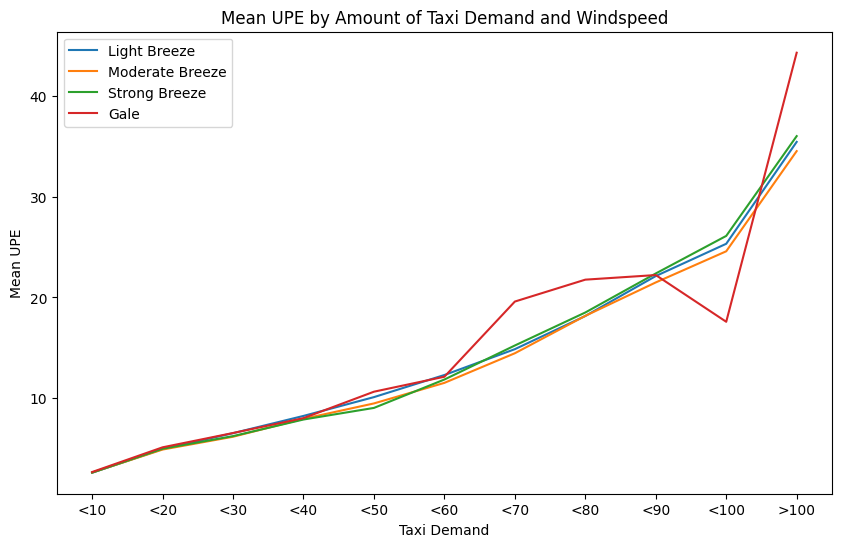

In [ ]:
plotter3('Windspeed', mean_values7)

In [ ]:
import matplotlib.pyplot as plt

def plotter4(category, mean_values1):
    # Convert the series to a DataFrame
    mean_values1 = mean_values1.reset_index()

    # Reorder 'new_col' values so that '0' appears at the end
    ordered_categories = list(range(1, 12))
    mean_values1['cat'] = pd.Categorical(mean_values1['cat'], categories=ordered_categories, ordered=True)
    mean_values1.sort_values('cat', inplace=True)



    # Separate the data by 'holiday'
    data_holiday_0 = mean_values1[mean_values1['tempcat'] == 1]
    data_holiday_1 = mean_values1[mean_values1['tempcat'] == 2]
    data_holiday_2 = mean_values1[mean_values1['tempcat'] == 3]
    data_holiday_3 = mean_values1[mean_values1['tempcat'] == 4]

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_holiday_0['cat'], data_holiday_0['UPE'], label='< 0°C')
    plt.plot(data_holiday_1['cat'], data_holiday_1['UPE'], label= ' 0 - 15°C')
    plt.plot(data_holiday_2['cat'], data_holiday_2['UPE'], label=' 15 - 30°C')
    plt.plot(data_holiday_3['cat'], data_holiday_3['UPE'], label= '> 30°C')

    # Set labels on x-axis
    #labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
    labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
    plt.xticks(ticks=range(1,12), labels=labels)

    plt.xlabel('Bicycle Demand')
    plt.ylabel('Mean UPE')
    plt.title('Mean UPE by Amount of Bicycle Demand and ' + category)
    plt.legend()
    plt.show()

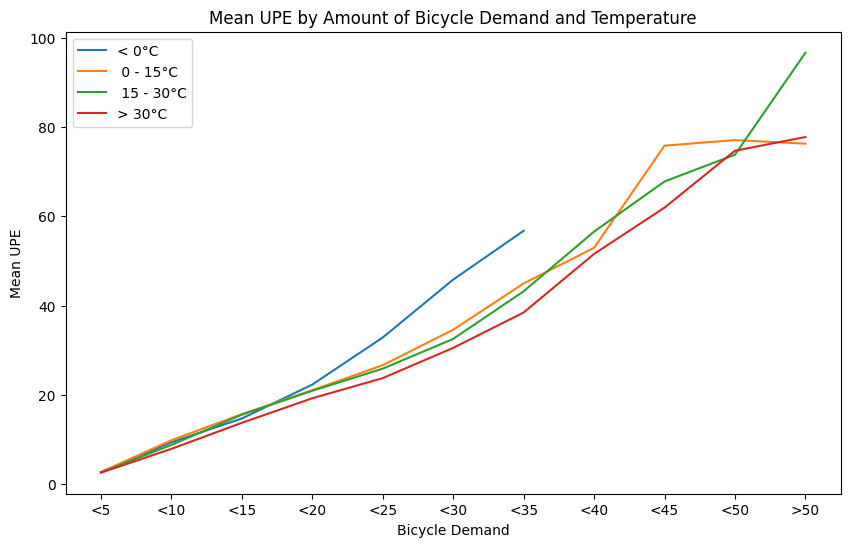

In [ ]:
plotter4('Temperature', mean_values8)

In [ ]:
import matplotlib.pyplot as plt

def plotter5(category, mean_values1):
    # Convert the series to a DataFrame
    mean_values1 = mean_values1.reset_index()

    # Reorder 'new_col' values so that '0' appears at the end
    ordered_categories = list(range(1, 12))
    mean_values1['cat'] = pd.Categorical(mean_values1['cat'], categories=ordered_categories, ordered=True)
    mean_values1.sort_values('cat', inplace=True)



    # Separate the data by 'holiday'
    data_holiday_0 = mean_values1[mean_values1['timecat'] == 1]
    data_holiday_1 = mean_values1[mean_values1['timecat'] == 2]
    data_holiday_2 = mean_values1[mean_values1['timecat'] == 3]
    data_holiday_3 = mean_values1[mean_values1['timecat'] == 4]

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_holiday_0['cat'], data_holiday_0['UPE'], label='Morning')
    plt.plot(data_holiday_1['cat'], data_holiday_1['UPE'], label= 'Afternoon')
    plt.plot(data_holiday_2['cat'], data_holiday_2['UPE'], label=' Evening')
    plt.plot(data_holiday_3['cat'], data_holiday_3['UPE'], label= 'Night')

    # Set labels on x-axis
    #labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
    labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
    plt.xticks(ticks=range(1,12), labels=labels)

    plt.xlabel('Bicycle Demand')
    plt.ylabel('Mean UPE')
    plt.title('Mean UPE by Amount of Bicycle Demand and ' + category)
    plt.legend()
    plt.show()

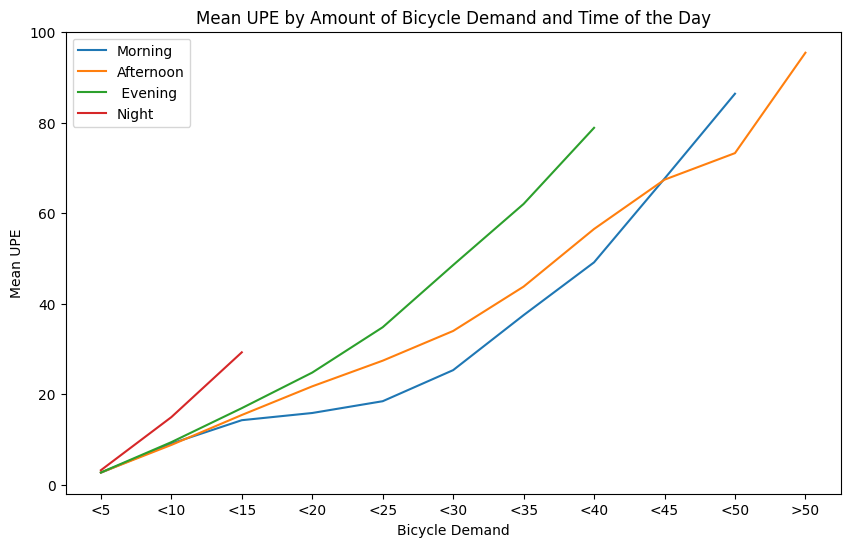

In [ ]:
plotter5("Time of the Day", mean_values9)

In [ ]:
import matplotlib.pyplot as plt

def plotter6(category, mean_values1):
    # Convert the series to a DataFrame
    mean_values1 = mean_values1.reset_index()

    # Reorder 'new_col' values so that '0' appears at the end
    ordered_categories = list(range(1, 12))
    mean_values1['cat'] = pd.Categorical(mean_values1['cat'], categories=ordered_categories, ordered=True)
    mean_values1.sort_values('cat', inplace=True)



    # Separate the data by 'holiday'
    data_holiday_0 = mean_values1[mean_values1['season'] == 1]
    data_holiday_1 = mean_values1[mean_values1['season'] == 2]
    data_holiday_2 = mean_values1[mean_values1['season'] == 3]
    data_holiday_3 = mean_values1[mean_values1['season'] == 4]

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_holiday_0['cat'], data_holiday_0['UPE'], label='Spring')
    plt.plot(data_holiday_1['cat'], data_holiday_1['UPE'], label= 'Summer')
    plt.plot(data_holiday_2['cat'], data_holiday_2['UPE'], label=' Fall')
    plt.plot(data_holiday_3['cat'], data_holiday_3['UPE'], label= 'Winter')

    # Set labels on x-axis
    #labels = ['<10', '<20', '<30', '<40', '<50', '<60', '<70', '<80', '<90', '<100','>100']
    labels = ['<5', '<10', '<15', '<20', '<25', '<30', '<35', '<40', '<45', '<50','>50']
    plt.xticks(ticks=range(1,12), labels=labels)

    plt.xlabel('Bicycle Demand')
    plt.ylabel('Mean UPE')
    plt.title('Mean UPE by Amount of Bicycle Demand and ' + category)
    plt.legend()
    plt.show()

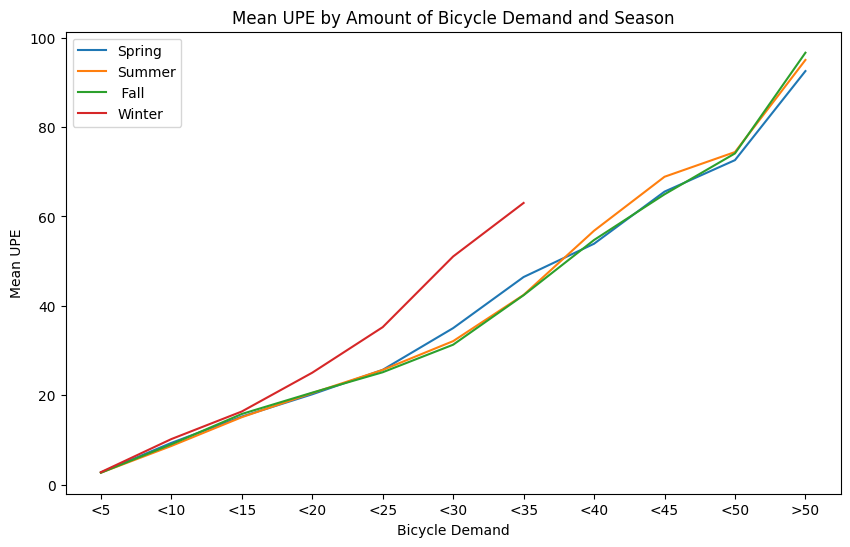

In [ ]:
plotter6("Season", mean_values10)

# Data Preparation
First Weather Data

In [ ]:
import datetime as dt

day = 24 * 60 * 60
week = 7 * day
year = 365.2425 * day

df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/chicago1.csv')
df2 = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/chicago2.csv')

weather = pd.concat([df,df2],ignore_index=True)

df["datetime"] = pd.to_datetime(df["datetime"])

def z_score(x, mean, std):
    return (x - mean) / std


mean_temp = weather["temp"].mean()
std_temp = weather["temp"].std()

mean_wind = weather["windspeed"].mean()
std_wind = weather["windspeed"].std()

weather["temp"] = weather["temp"].apply(z_score, args = (mean_temp, std_temp))
weather["windspeed"] = weather["windspeed"].apply(z_score, args = (mean_wind, std_wind))

liste = weather["conditions"].unique()

print(liste)

weather["Snow"] = weather['conditions'].apply(lambda x: 1 if 'snow' in x.lower() else 0)
weather["Rain"] = weather['conditions'].apply(lambda x: 1 if 'rain' in x.lower() else 0)
weather["Clear"] = weather['conditions'].apply(lambda x: 1 if 'clear' in x.lower() or 'cloudy' in x.lower() else 0)
weather["Cloudy"] = weather['conditions'].apply(lambda x: 1 if 'overcast' in x.lower()  else 0)

weather = weather.drop('conditions', axis=1)

weather_full = weather.loc[weather.index.repeat(4)].reset_index(drop=True)

weather_full = weather_full.drop('datetime', axis=1)
print(weather_full)
weather_full.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/weather.csv', header = None, index = None)

"""
for i in range(2617):
  for j in range(96):
    if i in liste:
      df2["Holiday"][i*96+j] = 1
    if weekends[i] == 1:
      df2["Weekend"][i*96+j] = 1
    df2["Time1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / day)
    df2["Time2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / day)
    df2["Week1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / week)
    df2["Week2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / week)
    df2["Year1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / year)
    df2["Year2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / year)

"""
sta = 0 * 85 + 0
end = sta + 12



#holidays = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays1.csv').values
#full_window_holidays = np.swapaxes(df2[sta:end, :], 0, 1)

#print(full_window_holidays[0])

#df1.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays1.csv', header = None, index = None)

['Overcast' 'Partially cloudy' 'Clear' 'Snow, Rain, Overcast'
 'Rain, Overcast' 'Snow, Partially cloudy' 'Snow, Rain, Partially cloudy'
 'Snow, Overcast' 'Snow, Rain' 'Rain, Partially cloudy' 'Rain' 'Snow']
            temp  windspeed  Snow  Rain  Clear  Cloudy
0      -1.434848   0.400248     0     0      0       1
1      -1.434848   0.400248     0     0      0       1
2      -1.434848   0.400248     0     0      0       1
3      -1.434848   0.400248     0     0      0       1
4      -1.451953   0.111802     0     0      0       1
...          ...        ...   ...   ...    ...     ...
251227  0.078962  -0.076315     0     0      1       0
251228  0.027646  -0.515255     0     0      1       0
251229  0.027646  -0.515255     0     0      1       0
251230  0.027646  -0.515255     0     0      1       0
251231  0.027646  -0.515255     0     0      1       0

[251232 rows x 6 columns]


Then the time-series data

In [ ]:
import datetime as dt

day = 24 * 60 * 60
week = 7 * day
year = 365.2425 * day

df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays.csv')
df["Date"] = pd.to_datetime(df["Date"])

holidays = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays.csv')

liste = []

for i in range(len(df['Date'])):
  liste.append((df['Date'][i] - pd.to_datetime('2013-01-01')).days)

data = {"Holiday": [0] * 251232, "Weekend": [0] * 251232, "Time1" : [0] * 251232, "Time2" : [0] * 251232,"Week1" : [0] * 251232,"Week2" : [0] * 251232,"Year1" : [0] * 251232,"Year2" : [0] * 251232}
df2 = pd.DataFrame(data)
weekends = [0,0,0,0,1,1,0] * 373 + [0,0,0,0,1,1]
print(liste)

for i in range(2617):
  for j in range(96):
    if i in liste:
      df2["Holiday"][i*96+j] = 1
    if weekends[i] == 1:
      df2["Weekend"][i*96+j] = 1
    df2["Time1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / day)
    df2["Time2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / day)
    df2["Week1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / week)
    df2["Week2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / week)
    df2["Year1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / year)
    df2["Year2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / year)


sta = 0 * 85 + 0
end = sta + 12


print(df2.head())

#holidays = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays1.csv').values
full_window_holidays = np.swapaxes(df2[sta:end, :], 0, 1)

print(full_window_holidays[0])

#df1.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/holidays1.csv', header = None, index = None)

[0, 20, 42, 48, 62, 131, 146, 166, 184, 244, 286, 314, 330, 358, 365, 384, 407, 412, 426, 495, 510, 530, 549, 608, 650, 679, 695, 723, 730, 748, 772, 776, 790, 859, 874, 901, 913, 979, 1014, 1044, 1059, 1088, 1095, 1112, 1137, 1140, 1161, 1223, 1245, 1265, 1280, 1343, 1378, 1407, 1410, 1423, 1455, 1462, 1476, 1503, 1511, 1525, 1594, 1609, 1629, 1645, 1707, 1742, 1774, 1787, 1819, 1826, 1840, 1868, 1875, 1889, 1958, 1973, 1993, 2010, 2071, 2106, 2135, 2141, 2151, 2164, 2183, 2184, 2191, 2211, 2233, 2239, 2322, 2337, 2357, 2375, 2435, 2477, 2505, 2522, 2548, 2549, 2556, 2575, 2598, 2603]


<ipython-input-22-db538f6c4906>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Time2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) * 2 * np.pi / day)
<ipython-input-22-db538f6c4906>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Week1"][i*96+j] = np.sin(((i*96+j) * 15 * 60) * 2 * np.pi / week)
<ipython-input-22-db538f6c4906>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Week2"][i*96+j] = np.cos(((i*96+j) * 15 * 60) *

   Holiday  Weekend     Time1     Time2     Week1     Week2     Year1  Year2
0        1        0  0.000000  1.000000  0.000000  1.000000  0.000000    1.0
1        1        0  0.065403  0.997859  0.009350  0.999956  0.000179    1.0
2        1        0  0.130526  0.991445  0.018699  0.999825  0.000358    1.0
3        1        0  0.195090  0.980785  0.028046  0.999607  0.000538    1.0
4        1        0  0.258819  0.965926  0.037391  0.999301  0.000717    1.0


Testing how a full window of input + output data would look like

In [ ]:
sta = 0 * 85 + 0
end = sta + 12

holidays = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/timeseries.csv').values
full_window_holidays = np.swapaxes(holidays[sta:end, :], 0, 1)

print(full_window_holidays[:, 3])


[1.00000000e+00 0.00000000e+00 1.95090322e-01 9.80785280e-01
 2.80462563e-02 9.99606626e-01 5.37586758e-04 9.99999856e-01]


In [ ]:
df2.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/timeseries.csv', index = None)

After downloading the grouped taxi data from the official website, I used this function to transform some data and get a file with all rides and their nodes and one file for the nodes

In [ ]:
def preprocessing(file1):

    df = pd.read_csv(file1)

    df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])

    node = df.groupby(["Pickup Centroid Latitude", "Pickup Centroid Longitude"]).size().reset_index().rename(columns={0:'count'})

    node = node.drop(columns = ['count'])

    node.insert(0, "ID", range(0, len(node)))

    new_df = pd.merge(df, node,  how='left', left_on=["Pickup Centroid Latitude", "Pickup Centroid Longitude"], right_on = ["Pickup Centroid Latitude", "Pickup Centroid Longitude"])

    new_df.to_csv("/Users/simonmarkmann/Downloads/Taxi_preprocessed.csv")

    node.to_csv("/Users/simonmarkmann/Downloads/Taxi_nodes.csv")

To calculate the distance between two taxi centroids

In [ ]:
import geopy.distance
import geopy

def distance_two(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.geodesic(coords_1, coords_2).km

Calculating a distance matrix for the taxi data and getting it into the right format for the PyTorch dataset

In [ ]:
"""distances = []

for i in range(len(nodes)):
  distancelist = []
  for j in range(len(nodes)):
    distancelist.append(distance_two(nodes["Pickup Centroid Latitude"][i],nodes["Pickup Centroid Longitude"][i],nodes["Pickup Centroid Latitude"][j],nodes["Pickup Centroid Longitude"][j]))
  distances.append(distancelist)

my_df = pd.DataFrame(distances)

my_df.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_W_228.csv', index=False, header=False)"""


df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])

all_nodes = []

for i in range(len(nodes)):
    all_nodes.append([0])


node_ids = {}
keys = range(len(nodes))
values = nodes["ID"]

for i in keys:
        node_ids[i] = values[i]


cur_timestamp = df["Trip Start Timestamp"][0]
countlist = [0 for x in range(len(nodes))]
index_json = 0

node_values = []

for i in tqdm(range(len(df))):
    if df["Trip Start Timestamp"][i] == cur_timestamp:
        countlist[df["ID"][i]] = df["Trip ID"][i]
    else:
        node_values.append(countlist)
        total = df["Trip Start Timestamp"][i] - cur_timestamp
        if total.seconds > 1000:
          for j in range(int(total.seconds/900) - 1):
            node_values.append([0 for x in range(len(nodes))])
        cur_timestamp = df["Trip Start Timestamp"][i]
        countlist = [0 for x in range(len(nodes))]
        countlist[df["ID"][i]] = df["Trip ID"][i]
node_values.append(countlist)

my_df1 = pd.DataFrame(node_values)

my_df1.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_228.csv', index=False, header=False)




In order to calculate the RSME for the top 5 or top 10 most used bicycle stations:

In [ ]:
df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv', header=None)


sums = []
for i in range(len(df.columns)):
  summe = df[i].sum()
  sums.append(summe)

top5 = sorted(range(len(sums)), key=lambda x: sums[x])[-5:]

top10 = sorted(range(len(sums)), key=lambda x: sums[x])[-10:]

top30 = sorted(range(len(sums)), key=lambda x: sums[x])[-50:]

print(top30)

top30sum = 0
for i in range(len(df.columns)):
  summe = df[i].sum()
  if i in top30:
    top30sum += summe

print(top30sum/sum(sums))


[187, 179, 138, 108, 50, 67, 204, 257, 254, 231, 190, 106, 26, 107, 113, 47, 102, 105, 101, 121, 112, 140, 244, 72, 219, 77, 57, 22, 51, 60, 103, 139, 88, 91, 79, 239, 62, 73, 92, 65, 87, 76, 183, 68, 78, 97, 84, 234, 71, 69]
0.9004108620253742


I realised that the bicycle data for the first 177 days of 2013 contains no data so I removed those days

In [ ]:
#df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data.csv', header=None)


train = df.head(1826*96)
train2013 = df.head(365*96)
train20131 = df.head(177*96)
val = df.iloc[1826*96:(1826+365)*96]
test = df.iloc[(1826+365)*96:]

def summe(data):
  sums = []
  for i in range(len(data.columns)):
    summe = data[i].sum()
    sums.append(summe)
  return sum(sums)

print(summe(train)/1826)
print(summe(train2013)/365)
print(summe(train20131)/177)
print(summe(val)/365)
print(summe(test)/426)


dfnew = df.iloc[178*96:]

print(dfnew)
#dfnew.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data_new.csv', header = False, index = False)

7560.780394304491
2081.61095890411
0.0
9855.5698630137
9630.058685446009
        0    1    2    3    4    5    6    7    8    9    ...  418  419  420  \
17088     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
17089     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
17090     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
17091     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
17092     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
251227    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
251228    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
251229    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
251230    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
251231    0    0    0    0    0    0    0    0 

This part reduced the amount of nodes from the 15m_flat_bike_count.h5 file by 50% and later calculated the similarity matrix but only keeping the 30 highest absolute values

In [ ]:
# Assuming your file is at the root of your Google Drive,
# you can change the path to the location of your h5 file
import tables as tb
import numpy as np

# Open the h5 file and transform into Pandas data frame
file_path = '/GoogleDrive/My Drive/Colab Notebooks/datasets/15m_flat_bike_count.h5'

with tb.open_file(file_path, mode='r') as h5_bike:
            b = h5_bike.get_node('/2013')[:]

dftest = pd.DataFrame(b)

#Figure out the nth percentile for the sums of the columns
sums = []
for i in range(len(dftest.columns)):
  summe = dftest[i].sum()
  sums.append(summe)

a = np.array(sums)
percentil = 50
p = np.percentile(a, percentil)


# Drop columns that are not part of the nth percentile
drop_indices= []
minus = 0

for i in range(len(dftest.columns)):
  summe = dftest[i].sum()
  if summe <= p:
    minus += summe
    drop_indices.append(i)

dftest = dftest.drop(dftest.columns[drop_indices], axis=1)

# Shorten dataset to the same size as the taxi data (2013/1/1 - 2020/3/1) = 2617 days
#  24h / 15min = 96 measurements a day, 2617 * 96 = 251232
dftest = dftest.head(251232)

# Save the result to google drive for later processing
#dftest.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data.csv', header = False, index = False)


print("The original dataset included " + str(sum(sums)) + " Bike rides")
print("I removed only " + str(minus) + " rides by removing " + str(percentil) + "% of the bike stations")
print("In other words, only " + str(round(100*minus/sum(sums), 2)) + "% of bike rides were removed")


# Calculate the correlation matrix using all of the data
#corr_matrix = dftest.corr()

# Keep only the 30 biggest absolute values of the matrix so that the graph will not have have too many edges
def keep_n_largest_abs(df, n):
    # Apply a function to each column (axis=0) of the DataFrame
    df = df.apply(lambda col: col.where(col.abs().isin(col.abs().nlargest(n)), 0))
    return df


n = 30
#sparse_matrix = keep_n_largest_abs(corr_matrix, n)

#sparse_matri.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_weights.csv')

The original dataset included 24700041 Bike rides
I removed 49197 rides by removing 50% of the bike stations
In other words, only 0.2% of bike rides were removed


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#dftest = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv', header=None)

# Calculate the correlation matrix using all of the data
#corr_matrix = dftest.corr()

# Keep only the 30 biggest absolute values of the matrix so that the graph will not have have too many edges
def keep_n_largest_abs(df, n):
    # Apply a function to each column (axis=0) of the DataFrame
    df = df.apply(lambda col: col.where(col.abs().isin(col.abs().nlargest(n)), 0))
    return df

df_T = dftest.transpose()

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(df_T)

# Convert the result into a pandas DataFrame,
# setting the column and index names to the original column names.
similarity_df = pd.DataFrame(similarity_matrix)

#print(similarity_df)

n = 50
#sparse_matrix = keep_n_largest_abs(corr_matrix, n)
sparse_matrix = keep_n_largest_abs(similarity_df, n)

sparse_matrix.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/taxi_weights_cosine_50.csv')

This part reduced the amount of nodes from the taxi rides file by 70% and later calculated the similarity matrix by keeping the 30 highest absolute values

In [ ]:
import numpy as np

df = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2281.csv', header = None)
df1 = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_W_228.csv', header = None)

sums = []
drop_indices= []

minus = 0

for i in range(len(df.columns)):
  summe = df[i].sum()
  sums.append(summe)
  if summe <= 4899:
    minus += summe
    drop_indices.append(i)

#df = df.drop(df.columns[drop_indices], axis=1)

#df1 = df1.drop(df1.columns[drop_indices], axis=1)

#df1 = df1.drop(drop_indices, axis=0)

print(sum(sums))

a = np.array(sums)
p = np.percentile(a, 70)

print(p)
print(minus)

print(minus/sum(sums))

#df.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv', index=False, header=False)
#df1.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_W_2283.csv', index=False, header=False)

#corr_matrix = df.corr()

#print(corr_matrix)


n = 30
#ssss = keep_n_largest_abs(corr_matrix, n)

#ssss.to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/taxi_weights.csv')


170208146
4899.0
220180
0.0012935926110140463


Calculating the mean and std once so that I dont have to calculate them every time I run the code

In [ ]:
#print(np.mean(pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv', header=None).values), np.std(pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv', header=None).values))
print(np.mean(pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data_new.csv', header=None).values), np.std(pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data_new.csv', header=None).values))


0.21459733142892176 0.9983478235701564


# Map Creation

In [ ]:
!pip install Shapely==1.7.1
!pip install cartopy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Shapely: filename=Shapely-1.7.1-cp310-cp310-linux_x86_64.whl size=1039446 sha256=ed12130ba2af6412151c7a1c950fe9e0d41ef61e098d2bf20ccb463b7a3a43ae
  Stored in directory: /root/.cache/pip/wheels/2e/fa/97/c85f587c35afcaf4a81c481741d36592518d1e50445572f0d4
Successfully built Shapely
  Attempting uninstall: Shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.1 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102756 sha256=060938048893efe4814daea

In [ ]:
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from geopy import distance
import numpy as np
%config Completer.use_jedi = False

In [ ]:
df_zones = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/Taxi_nodes.csv', index_col=0)
df_zones = df_zones.drop("ID", axis = 1)
df_zones.columns = ['lat', 'lng']
df_zones.shape
print(df_zones)


           lat        lng
0    41.650222 -87.599463
1    41.651922 -87.564929
2    41.660136 -87.602848
3    41.660493 -87.646958
4    41.663671 -87.540936
..         ...        ...
856  42.015720 -87.687116
857  42.015934 -87.666536
858  42.016011 -87.680162
859  42.016046 -87.673334
860  42.021224 -87.669825

[861 rows x 2 columns]


In [ ]:
df_st = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/station-locations-bike.csv', index_col=0)
#df_st.head()
print(df_st)


           lng        lat
id                       
2   -87.622371  41.875010
3   -87.615355  41.867226
4   -87.613348  41.856268
5   -87.627732  41.873990
6   -87.612795  41.885042
..         ...        ...
727 -87.655394  41.687491
728 -87.681304  41.691236
730 -87.712830  41.691323
731 -87.564624  41.717898
732 -87.546176  41.648561

[684 rows x 2 columns]


In [ ]:
df_locs = pd.concat([df_zones, df_st])
print(df_locs)

           lat        lng
0    41.650222 -87.599463
1    41.651922 -87.564929
2    41.660136 -87.602848
3    41.660493 -87.646958
4    41.663671 -87.540936
..         ...        ...
727  41.687491 -87.655394
728  41.691236 -87.681304
730  41.691323 -87.712830
731  41.717898 -87.564624
732  41.648561 -87.546176

[1545 rows x 2 columns]


In [ ]:
map_dim = (60, 90)
offset = 0.002
lng_intervals = np.linspace(df_locs.lng.min() - offset, df_locs.lng.max() + offset, map_dim[0] + 1)
lat_intervals = np.linspace(df_locs.lat.min() - offset, df_locs.lat.max() + offset, map_dim[1] + 1)

In [ ]:
from scipy.interpolate import griddata

def interp_map(arr, xy, X, Y, method='nearest', fill_value=np.nan):
    '''
    xy : Longitude and latitude of the available zones.
    X : x-coordinates of the mesh grid.
    Y : y-coordinates of the mesh grid.
    arr : Trip counts values used to interpolate.
    '''
    return griddata(xy, arr, (X, Y), method=method, fill_value=fill_value)

In [ ]:
def check_coverage(df, map_dim, offset=0.005, xrange=None, yrange=None):
    xy = df.values
    x = xy[:, 0]
    y = xy[:, 1]
    if xrange is None or yrange is None:
        xrange = (x.min(), x.max())
        yrange = (y.min(), y.max())
        xstep, ystep = 0, 0
    else:
        xstep = (xrange[1] - xrange[0] + 2 * offset) / map_dim[0]
        ystep = (yrange[1] - yrange[0] + 2 * offset) / map_dim[1]
    xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, map_dim[0])
    ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, map_dim[1])
    X, Y = np.meshgrid(xnew, ynew, indexing='ij')
    interp = interp_map(df.index.values, df.values, X, Y, method='nearest')
    print(interp.shape)
    print('(x_step, y_step) = ({:.5f}, {:.5f})'.format(xnew[1] - xnew[0], ynew[1] - ynew[0]))
    print('(min_interp, max_interp) = ({}, {})'.format(interp.min().round(2), interp.max().round(2)))
    print('n_unique_interp = {}'.format(np.unique(interp).shape[0]))
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    axs[0].scatter(df.lng, df.lat, s=5)
    axs[0].set_xticks(xnew)
    axs[0].set_yticks(ynew)
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].grid()
    axs[1].imshow(interp.T, origin='lower')
    axs[2].hist(interp.ravel(), bins=30, edgecolor='k')
    plt.show()
    return X, Y, interp

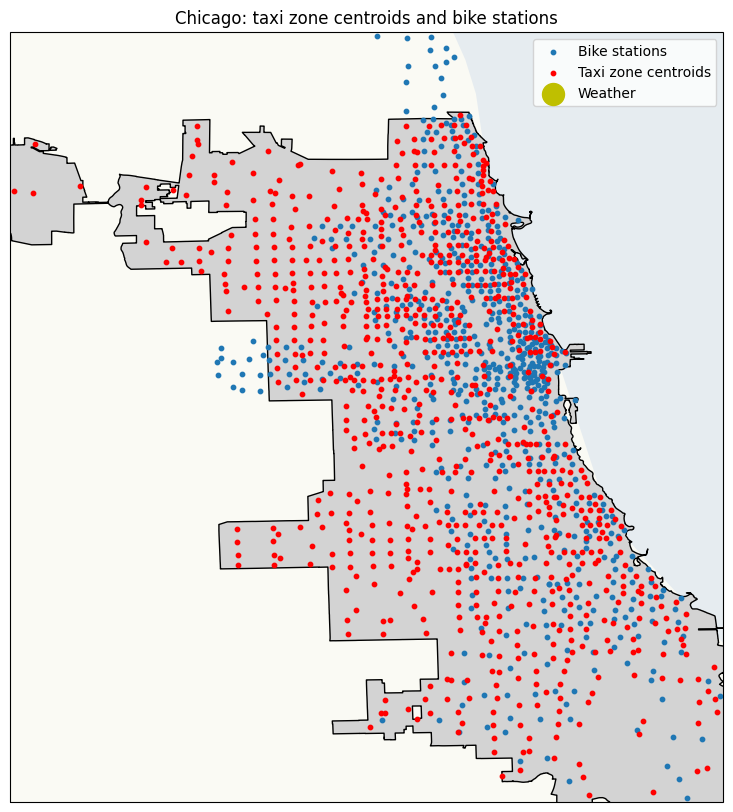

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.2)
ax.add_feature(cfeature.LAKES, alpha=0.2)
lon_lat_ranges = [lng_intervals.min(), lng_intervals.max(), lat_intervals.min(), lat_intervals.max()]
ax.set_extent(lon_lat_ranges)
fname = '/GoogleDrive/My Drive/Colab Notebooks/datasets/boundaries/geo_export_98bcadad-92bb-4ea8-a546-8ee314c1a35a.shp'
df_shp = pd.DataFrame({'zone': [r.attributes for r in Reader(fname).records()],
                           'poly': Reader(fname).geometries()})

shape_feature = ShapelyFeature(df_shp.poly, ccrs.PlateCarree(), edgecolor='k', facecolor='lightgray')


ax.add_feature(shape_feature)
ax.scatter(df_st.lng, df_st.lat, s=10, label='Bike stations', zorder = 10)
ax.scatter(df_zones.lng, df_zones.lat, s=10, c='r', label='Taxi zone centroids', zorder = 10)
"""for idx, lng in enumerate(lng_intervals):
    ax.axvline(lng, color='grey', linewidth=0.5)
    #ax.text(lng, lat_intervals.max() - 0.01, s=idx)
for idx, lat in enumerate(lat_intervals):
    ax.axhline(lat, color='grey', linewidth=0.5)
    #ax.text(lng_intervals.max() - 0.01, lat, s=idx)"""
#41.884	-87.632
ax.scatter([-87.632], [41.884], s=250, c='y', label='Weather')
ax.set_extent(lon_lat_ranges)
#ax.set_title('Chicago overlayed with a 90x60 grid')
#plt.savefig('./graphs/chicago-grid.pdf', bbox_inches='tight')
ax.set_aspect('equal')
ax.set_title('Chicago: taxi zone centroids and bike stations')
ax.legend(loc='upper right')
plt.show()





In [ ]:
import os, time
import requests, glob, warnings

df_colnames = pd.DataFrame(columns=['shape', 'columns', 'n_pickup', 'n_dropoff'])
for file in glob.glob('/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/*ivvy*.csv'):
    df = pd.read_csv(file)
    period = os.path.basename(file).replace('Divvy_Trips_', '').replace('-divvy-tripdata', '').replace('.csv', '')
    #print(period)
    df_colnames.loc[period, 'shape'] = df.shape
    df_colnames.loc[period, 'columns'] = str(df.columns.values)
    try:
        df_colnames.loc[period, 'n_pickup'] = df.start_station_id.nunique()
    except AttributeError:
        try:
            df_colnames.loc[period, 'n_pickup'] = df.from_station_id.nunique()
        except AttributeError:
            df_colnames.loc[period, 'n_pickup'] = df['03 - Rental Start Station ID'].nunique()
    try:
        df_colnames.loc[period, 'n_dropoff'] = df.end_station_id.nunique()
    except AttributeError:
        try:
            df_colnames.loc[period, 'n_dropoff'] = df.to_station_id.nunique()
        except AttributeError:
            df_colnames.loc[period, 'n_dropoff'] = df['02 - Rental End Station ID'].nunique()

df_colnames.sort_index().to_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bikes_colnames.csv')


<ipython-input-8-d1d36fe7c726>:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


KeyboardInterrupt: ignored

In [ ]:
sum([df_colnames.loc[period, 'shape'][0] for period in df_colnames.index])

13822258

In [ ]:
df_colnames['columns'].nunique()

3

In [ ]:
lookup_files = [
    'Divvy_Stations_2013.csv',
    'Divvy_Stations_2014-Q3Q4.csv',
    'Divvy_Stations_2015.csv',
    'Divvy_Stations_2016_Q1Q2.csv',
    'Divvy_Stations_2016_Q3.csv',
    'Divvy_Stations_2016_Q4.csv',
    'Divvy_Stations_2017_Q1Q2.csv',
    'Divvy_Stations_2017_Q3Q4.csv',
]
cols = ['id', 'name', 'longitude', 'latitude']

base = '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_station/'
df_stations_lookup = pd.read_excel(base + 'Divvy_Stations_2014-Q1Q2.xlsx')[cols]

for f in lookup_files:
    df_stations_lookup = pd.concat([df_stations_lookup, pd.read_csv(base + f)[cols]])

# Remove lng-lat from (Temp) stations (later they are dropped):
df_stations_lookup.loc[df_stations_lookup.name.str.contains('(Temp)', regex=False),
                       ['longitude', 'latitude']] = np.nan
# Remove (*) from station names:
df_stations_lookup.loc[:, 'name'] = df_stations_lookup.name.str.replace(' (*)', '', regex=False)
df_stations_lookup.columns = cols = ['id', 'name', 'lng', 'lat']
# Clean up:
df_stations_lookup.sort_values('id', inplace=True)
df_stations_lookup.reset_index(inplace=True, drop=True)
df_stations_lookup.drop_duplicates(inplace=True)
df_stations_lookup.dropna(subset=['lng', 'lat'], inplace=True)
# Check:
print('Number of unique station ids:', df_stations_lookup.id.nunique())
print('Number of unique station ids + long-lat-name:', df_stations_lookup.shape[0])
print('Number of unique station ids which are duplicated:',
      df_stations_lookup[df_stations_lookup.duplicated('id', keep=False)].id.nunique())
# Keep full data for a later check:
df_full = df_stations_lookup.copy()

Number of unique station ids: 586
Number of unique station ids + long-lat-name: 1106
Number of unique station ids which are duplicated: 303


In [ ]:
df_stations_lookup = df_stations_lookup.groupby('id')[['lng', 'lat']].mean()
print('Shape:', df_stations_lookup.shape[0])
df_stations_lookup.head()

Shape: 586


,lng,lat
id,,
2,-87.622371,41.875010
3,-87.615355,41.867226
4,-87.613348,41.856268
5,-87.627732,41.873990
6,-87.612795,41.885042


In [ ]:
d_lu = {'/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2013.csv': 'Divvy_Stations_2013.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2014-Q3-07.csv': 'Divvy_Stations_2014-Q3Q4.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2014-Q3-0809.csv': 'Divvy_Stations_2014-Q3Q4.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2014-Q4.csv': 'Divvy_Stations_2014-Q3Q4.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2014_Q1Q2.csv': 'Divvy_Stations_2014-Q1Q2.xlsx',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2015-Q1.csv': 'Divvy_Stations_2015.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2015-Q2.csv': 'Divvy_Stations_2015.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2015_07.csv': 'Divvy_Stations_2015.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2015_08.csv': 'Divvy_Stations_2015.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2015_09.csv': 'Divvy_Stations_2015.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2015_Q4.csv': 'Divvy_Stations_2015.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2016_04.csv': 'Divvy_Stations_2016_Q1Q2.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2016_05.csv': 'Divvy_Stations_2016_Q1Q2.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2016_06.csv': 'Divvy_Stations_2016_Q1Q2.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2016_Q1.csv': 'Divvy_Stations_2016_Q1Q2.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2016_Q3.csv': 'Divvy_Stations_2016_Q3.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2016_Q4.csv': 'Divvy_Stations_2016_Q4.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2017_Q1.csv': 'Divvy_Stations_2017_Q1Q2.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2017_Q2.csv': 'Divvy_Stations_2017_Q1Q2.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2017_Q3.csv': 'Divvy_Stations_2017_Q3Q4.csv',
        '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/Divvy_Trips_2017_Q4.csv': 'Divvy_Stations_2017_Q3Q4.csv'
        }

In [ ]:
import glob, os

base_lu = '/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_station/'
for file in sorted(glob.glob('/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/*ivvy*.csv')):
    if '2018' in file or '2019' in file or '2020' in file:
        continue
    df = pd.read_csv(file)
    period = os.path.basename(file).replace('Divvy_Trips_', '').replace('.csv', '')
    #print(period)
    if 'csv' in d_lu[file]:
        df_lu = pd.read_csv(base_lu + d_lu[file])
    else:
        df_lu = pd.read_excel(base_lu + d_lu[file])
    if set(df.from_station_id.unique()) <= set(df_lu.id):
        print('alright!', period)
    else:
        print('wrong!', period)
    if df_lu.id.nunique() != df_lu.shape[0]:
        print('duplicated look-up ids for', period)

<ipython-input-10-1e9bdf851920>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


alright! 2013
alright! 2014-Q3-07
alright! 2014-Q3-0809
alright! 2014-Q4
alright! 2014_Q1Q2
alright! 2015-Q1
alright! 2015-Q2
alright! 2015_07
wrong! 2015_08
wrong! 2015_09
wrong! 2015_Q4
alright! 2016_04
alright! 2016_05
alright! 2016_06
alright! 2016_Q1
alright! 2016_Q3
alright! 2016_Q4
alright! 2017_Q1
alright! 2017_Q2
alright! 2017_Q3
alright! 2017_Q4


In [ ]:
lookup = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/station-locations-bike.csv')
df_dict = {key: 0 for key in lookup['id']}

for file in sorted(glob.glob('/GoogleDrive/My Drive/Colab Notebooks/datasets/divvy_rides/*ivvy*.csv')):
  df = pd.read_csv(file)

  for i in range(len(df)):
    df_dict[df["from_station_id"][i]] += 1

print(df_dict)

<ipython-input-11-07835c2dd2f1>:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


{2: 43695, 3: 83540, 4: 59250, 5: 37470, 6: 61262, 7: 30636, 9: 2455, 11: 771, 12: 2073, 13: 48351, 14: 15474, 15: 17257, 16: 28663, 17: 29789, 18: 40935, 19: 30047, 20: 38807, 21: 37977, 22: 30296, 23: 19745, 24: 81759, 25: 62294, 26: 110256, 27: 18151, 28: 23170, 29: 33869, 30: 21704, 31: 64207, 32: 20657, 33: 58685, 34: 41087, 35: 325296, 36: 97362, 37: 73179, 38: 42666, 39: 32574, 40: 29456, 41: 34612, 42: 12819, 43: 116548, 44: 71311, 45: 50700, 46: 35911, 47: 83923, 48: 77553, 49: 95020, 50: 52933, 51: 67862, 52: 100782, 53: 65164, 54: 33337, 55: 19296, 56: 77660, 57: 30996, 58: 64626, 59: 86131, 60: 45753, 61: 44463, 62: 29226, 66: 86170, 67: 63306, 68: 28590, 69: 74962, 71: 51582, 72: 32211, 73: 46919, 74: 76372, 75: 104105, 76: 210257, 77: 140790, 80: 44072, 81: 100314, 84: 38482, 85: 163988, 86: 23894, 87: 29694, 88: 26987, 89: 29065, 90: 158330, 91: 188315, 92: 23982, 93: 34684, 94: 87321, 95: 1082, 96: 27186, 97: 82471, 98: 61339, 99: 75232, 100: 85455, 101: 3271, 102: 1063

In [ ]:
k = list(df_dict.keys())
print(k)
dict_values = list(df_dict.values())
print(dict_values)


a = np.array(dict_values)
percentil = 50
p = np.percentile(a, percentil)


# Drop columns that are not part of the nth percentile
drop_indices= []
minus = 0

for i in range(len(dict_values)):
  summe = dict_values[i]
  if summe <= p:
    minus += summe
    drop_indices.append(i)

print(drop_indices)

print(minus/sum(dict_values))


[2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239,

In [ ]:
df_st_new = df_st[~df_st.index.isin(drop_indices)]

In [ ]:
df_zones_new = df_zones[~df_zones.index.isin(drop_indices)]

In [ ]:
print(df_zones)

           lat        lng
0    41.650222 -87.599463
1    41.651922 -87.564929
2    41.660136 -87.602848
3    41.660493 -87.646958
4    41.663671 -87.540936
..         ...        ...
856  42.015720 -87.687116
857  42.015934 -87.666536
858  42.016011 -87.680162
859  42.016046 -87.673334
860  42.021224 -87.669825

[861 rows x 2 columns]


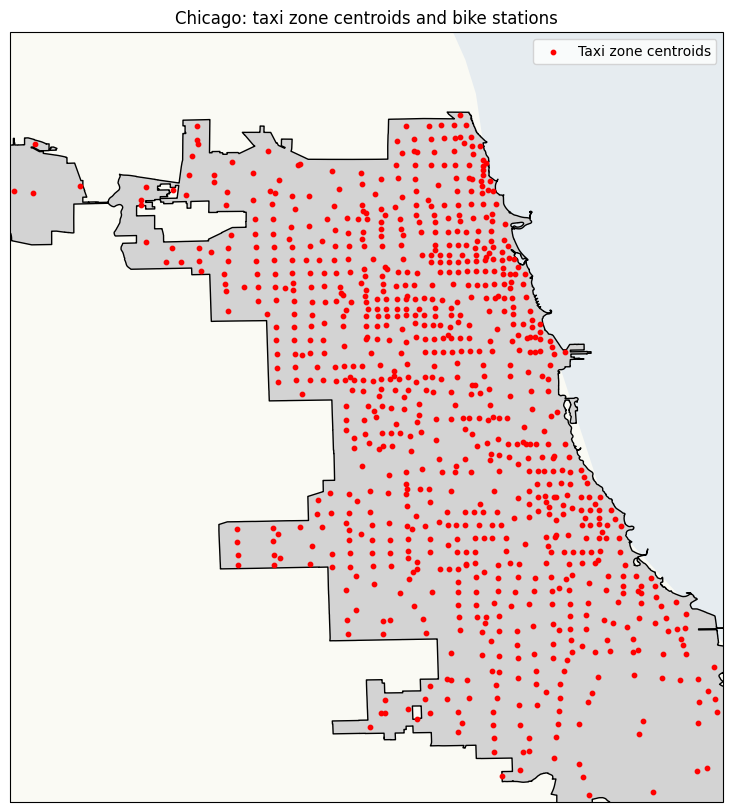

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.add_feature(cfeature.LAND, alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.2)
ax.add_feature(cfeature.LAKES, alpha=0.2)
lon_lat_ranges = [lng_intervals.min(), lng_intervals.max(), lat_intervals.min(), lat_intervals.max()]
ax.set_extent(lon_lat_ranges)
fname = '/GoogleDrive/My Drive/Colab Notebooks/datasets/boundaries/geo_export_98bcadad-92bb-4ea8-a546-8ee314c1a35a.shp'
df_shp = pd.DataFrame({'zone': [r.attributes for r in Reader(fname).records()],
                           'poly': Reader(fname).geometries()})

shape_feature = ShapelyFeature(df_shp.poly, ccrs.PlateCarree(), edgecolor='k', facecolor='lightgray')


ax.add_feature(shape_feature)
#ax.scatter(df_st_new.lng, df_st_new.lat, s=10, label='Bike stations', zorder = 10)
ax.scatter(df_zones.lng, df_zones.lat, s=10, c='r', label='Taxi zone centroids', zorder = 10)
"""for idx, lng in enumerate(lng_intervals):
    ax.axvline(lng, color='grey', linewidth=0.5)
    #ax.text(lng, lat_intervals.max() - 0.01, s=idx)
for idx, lat in enumerate(lat_intervals):
    ax.axhline(lat, color='grey', linewidth=0.5)
    #ax.text(lng_intervals.max() - 0.01, lat, s=idx)"""
ax.set_extent(lon_lat_ranges)
#ax.set_title('Chicago overlayed with a 90x60 grid')
#plt.savefig('./graphs/chicago-grid.pdf', bbox_inches='tight')
ax.set_aspect('equal')
ax.set_title('Chicago: taxi zone centroids and bike stations')
ax.legend(loc='upper right')
plt.show()


# Model variations and Evaluations


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class ST_GAT2(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=32, dropout=0.0): #32
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT2, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        lstm1_hidden_size = 256 #256
        lstm2_hidden_size = 512 #512

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0.1, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param) #xavier_uniform_
        #LSTM only
        self.lstmonly = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=16, num_layers=1)
        for name, param in self.lstmonly.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.linearlstm = torch.nn.Linear(16, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linearlstm.weight)

        #BiLSTM
        '''self.bilstm = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=8, num_layers=1, bidirectional = True)
        for name, param in self.bilstm.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.linearbilstm = torch.nn.Linear(16, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linearbilstm.weight)'''


        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

        self.timeseries = torch.nn.Linear(8,self.n_nodes)
        torch.nn.init.xavier_uniform_(self.linear.weight)

        self.fc = torch.nn.Linear(6, 4)
        torch.nn.init.xavier_uniform_(self.fc.weight)

        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(self.n_pred+2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_pred),
        )

        self.lstm3 = torch.nn.LSTM(input_size=6, hidden_size = self.n_nodes, num_layers=1)
        for name, param in self.lstm3.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)


    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x = data.x
        t = np.array(data.timeseries)
        w = np.array(data.weather)

        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
            t = torch.FloatTensor(t)
            w = torch.FloatTensor(w)
        else:
            x = torch.cuda.FloatTensor(x)
            t = torch.cuda.FloatTensor(t)
            w = torch.cuda.FloatTensor(w)

        # gat layer: output of gat: [11400, 12]
        """x = self.gat(x, edge_index, edge_attr)"""

        #LSTM only!!
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        x, _ = self.lstmonly(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linearlstm(x)


        '''#BiLSTM!!!
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        x, _ = self.bilstm(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linearbilstm(x)'''


        """# RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)"""

        t = self.timeseries(t)
        # [50, 228*9] -> [50, 228, 9]
        t = t.flatten().unsqueeze(-1)

        w, _ = self.lstm3(w)
        w = w.flatten().unsqueeze(-1)
        #print(w)
        #t = t.repeat_interleave(n_node, dim=0)

        #t = torch.movedim(t, 1, 0)
        #print(t)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))

        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))

        x3 = torch.cat([x,t,w], dim = 1)

        x3 = self.linear_relu_stack(x3)

        return x3


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class ST_GAT3(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=32, dropout=0.0): #32
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT3, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        lstm1_hidden_size = 256 #256
        lstm2_hidden_size = 512 #512

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0.1, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param) #xavier_uniform_
        #LSTM only
        """self.lstmonly = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=16, num_layers=1)
        for name, param in self.lstmonly.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.linearlstm = torch.nn.Linear(16, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linearlstm.weight)"""

        #BiLSTM
        self.bilstm = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=8, num_layers=1, bidirectional = True)
        for name, param in self.bilstm.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.linearbilstm = torch.nn.Linear(16, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linearbilstm.weight)


        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

        self.timeseries = torch.nn.Linear(8,self.n_nodes)
        torch.nn.init.xavier_uniform_(self.linear.weight)

        self.fc = torch.nn.Linear(6, 4)
        torch.nn.init.xavier_uniform_(self.fc.weight)

        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(self.n_pred+2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_pred),
        )

        self.lstm3 = torch.nn.LSTM(input_size=6, hidden_size = self.n_nodes, num_layers=1)
        for name, param in self.lstm3.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)


    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x = data.x
        t = np.array(data.timeseries)
        w = np.array(data.weather)

        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
            t = torch.FloatTensor(t)
            w = torch.FloatTensor(w)
        else:
            x = torch.cuda.FloatTensor(x)
            t = torch.cuda.FloatTensor(t)
            w = torch.cuda.FloatTensor(w)

        # gat layer: output of gat: [11400, 12]
        """x = self.gat(x, edge_index, edge_attr)"""

        #LSTM only!!
        """batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        x, _ = self.lstmonly(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linearlstm(x)"""


        #BiLSTM!!!
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        x, _ = self.bilstm(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linearbilstm(x)


        """# RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)"""

        t = self.timeseries(t)
        # [50, 228*9] -> [50, 228, 9]
        t = t.flatten().unsqueeze(-1)

        w, _ = self.lstm3(w)
        w = w.flatten().unsqueeze(-1)
        #print(w)
        #t = t.repeat_interleave(n_node, dim=0)

        #t = torch.movedim(t, 1, 0)
        #print(t)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))

        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))

        x3 = torch.cat([x,t,w], dim = 1)

        x3 = self.linear_relu_stack(x3)

        return x3


In [ ]:
@torch.no_grad()
def eval2(device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """


    rmse1 = 0
    rmse2 = 0
    rmse3 = 0
    rmse4 = 0
    rmse5 = 0
    rmse6 = 0
    rmse7 = 0
    rmse8 = 0
    rmse = 0
    mae = 0
    quant = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:

            xval = batch.x
            truth = batch.y.view(torch.Size([len(batch)* config['N_NODE'], config['N_PRED']]))

            if i == 0:
                y_pred = torch.zeros(len(dataloader), len(batch) * config['N_NODE'], config['N_PRED'])
                y_truth = torch.zeros(len(dataloader), len(batch) * config['N_NODE'], config['N_PRED'])


            truth = un_z_score(truth, mean, std_dev)
            xval = un_z_score(xval, mean, std_dev)

            tensors = torch.split(truth, 1, dim=1)

            mean_values = torch.mean(xval, dim=1)

            # Expand dimensions
            mean_values = mean_values.unsqueeze(1)

            # Repeat the mean value 4 times in each row
            output_tensor = mean_values.repeat(1, config['N_PRED'])

            y_pred[i, :len(batch) * config['N_NODE'], :] = output_tensor
            y_truth[i, :len(batch) * config['N_NODE'], :] = truth

            tensors2 = torch.split(output_tensor, 1, dim=1)

            truth0 = tensors[0]
            truth1 = tensors[1]
            truth2 = tensors[2]
            truth3 = tensors[3]
            truth4 = tensors[4]
            truth5 = tensors[5]
            truth6 = tensors[6]
            truth7 = tensors[7]

            pred0 = tensors2[0]
            pred1 = tensors2[1]
            pred2 = tensors2[2]
            pred3 = tensors2[3]
            pred4 = tensors2[4]
            pred5 = tensors2[5]
            pred6 = tensors2[6]
            pred7 = tensors2[7]
            """print("Batch.x:", batch.x, "Batch.x Has shape:", batch.x.shape)
            print("Batch", batch, "batch has Shape")
            print("Truth nach un_zscore", truth, "Truth has shape:", truth.shape)
            print("Pred nach un_zscore", pred, "Pred has shape", pred.shape)
            print("Truth0 und truth 1:", truth0, truth1, "Truth0 and 1 shape:", truth0.shape, truth1.shape)
            print(pred0,pred1)"""

            rmse1 += RMSE(truth0, pred0)
            rmse2 += RMSE(truth1, pred1)
            rmse3 += RMSE(truth2, pred2)
            rmse4 += RMSE(truth3, pred3)
            rmse5 += RMSE(truth4, pred4)
            rmse6 += RMSE(truth5, pred5)
            rmse7 += RMSE(truth6, pred6)
            rmse8 += RMSE(truth7, pred7)
            n += 1

    rmse1, rmse2, rmse3, rmse4,rmse5,rmse6,rmse7,rmse8, rmse, mae, quant = rmse1 / n, rmse2 / n, rmse3 / n, rmse4/n,rmse5/n,rmse6/n,rmse7/n,rmse8/n, rmse/n, mae/n, quant/n
    #rmse1, rmse2, rmse3, rmse4, rmse, mae, quant = rmse1 / n, rmse2 / n, rmse3 / n, rmse4/n, rmse/n, mae/n, quant/n

    #print(f'{type}, RMSE1: {rmse1}, RMSE2: {rmse2}, RMSE3: {rmse3}, RMSE4: {rmse4}, RMSE5: {rmse5},RMSE6: {rmse6},RMSE7: {rmse7},RMSE8: {rmse8},RMSE:{rmse} , MAE:{mae}, UPE:{quant} ')

    #get the average score for each metric in each batch
    return round(rmse1.item(),3), round(rmse2.item(),3), round(rmse3.item(),3),round(rmse4.item(),3),round(rmse5.item(),3),round(rmse6.item(),3),round(rmse7.item(),3),round(rmse8.item(),3),rmse, mae, quant,  y_pred, y_truth
    #return round(rmse1.item(),3), round(rmse2.item(),3), round(rmse3.item(),3),round(rmse4.item(),3),rmse, mae, quant,  y_pred, y_truth



In [ ]:
@torch.no_grad()
def eval3(device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """

    rmse1 = 0
    rmse2 = 0
    rmse3 = 0
    rmse4 = 0
    rmse5 = 0
    rmse6 = 0
    rmse7 = 0
    rmse8 = 0
    rmse = 0
    mae = 0
    quant = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            xval = batch.x
            truth = batch.y.view(torch.Size([len(batch) * config['N_NODE'], config['N_PRED']]))

            if i == 0:
                y_pred = torch.zeros(len(dataloader), len(batch) * config['N_NODE'], config['N_PRED'])
                y_truth = torch.zeros(len(dataloader), len(batch) * config['N_NODE'], config['N_PRED'])


            truth = un_z_score(truth, mean, std_dev)
            xval = un_z_score(xval, mean, std_dev)

            tensors = torch.split(truth, 1, dim=1)

            last_values = xval[:, -1]

            # Expand dimensions
            last_values = last_values.unsqueeze(1)

            # Repeat the last value 4 times in each row
            output_tensor = last_values.repeat(1, config['N_PRED'])

            y_pred[i, :len(batch) * config['N_NODE'], :] = output_tensor
            y_truth[i, :len(batch) * config['N_NODE'], :] = truth

            tensors2 = torch.split(output_tensor, 1, dim=1)

            truth0 = tensors[0]
            truth1 = tensors[1]
            truth2 = tensors[2]
            truth3 = tensors[3]
            truth4 = tensors[4]
            truth5 = tensors[5]
            truth6 = tensors[6]
            truth7 = tensors[7]

            pred0 = tensors2[0]
            pred1 = tensors2[1]
            pred2 = tensors2[2]
            pred3 = tensors2[3]
            pred4 = tensors2[4]
            pred5 = tensors2[5]
            pred6 = tensors2[6]
            pred7 = tensors2[7]
            """print("Batch.x:", batch.x, "Batch.x Has shape:", batch.x.shape)
            print("Batch", batch, "batch has Shape")
            print("Truth nach un_zscore", truth, "Truth has shape:", truth.shape)
            print("Pred nach un_zscore", pred, "Pred has shape", pred.shape)
            print("Truth0 und truth 1:", truth0, truth1, "Truth0 and 1 shape:", truth0.shape, truth1.shape)
            print(pred0,pred1)"""

            rmse1 += RMSE(truth0, pred0)
            rmse2 += RMSE(truth1, pred1)
            rmse3 += RMSE(truth2, pred2)
            rmse4 += RMSE(truth3, pred3)
            rmse5 += RMSE(truth4, pred4)
            rmse6 += RMSE(truth5, pred5)
            rmse7 += RMSE(truth6, pred6)
            rmse8 += RMSE(truth7, pred7)
            n += 1

    rmse1, rmse2, rmse3, rmse4,rmse5,rmse6,rmse7,rmse8, rmse, mae, quant = rmse1 / n, rmse2 / n, rmse3 / n, rmse4/n,rmse5/n,rmse6/n,rmse7/n,rmse8/n, rmse/n, mae/n, quant/n
    #rmse1, rmse2, rmse3, rmse4, rmse, mae, quant = rmse1 / n, rmse2 / n, rmse3 / n, rmse4/n, rmse/n, mae/n, quant/n

    #print(f'{type}, RMSE1: {rmse1}, RMSE2: {rmse2}, RMSE3: {rmse3}, RMSE4: {rmse4}, RMSE5: {rmse5},RMSE6: {rmse6},RMSE7: {rmse7},RMSE8: {rmse8},RMSE:{rmse} , MAE:{mae}, UPE:{quant} ')

    #get the average score for each metric in each batch
    return round(rmse1.item(),3), round(rmse2.item(),3), round(rmse3.item(),3),round(rmse4.item(),3),round(rmse5.item(),3),round(rmse6.item(),3),round(rmse7.item(),3),round(rmse8.item(),3),rmse, mae, quant,  y_pred, y_truth
    #return round(rmse1.item(),3), round(rmse2.item(),3), round(rmse3.item(),3),round(rmse4.item(),3),rmse, mae, quant,  y_pred, y_truth






In [ ]:
#top50 bike stations: [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
# how much they make up of the total 0.5887405118802201

#top 50 taxi stations: [187, 179, 138, 108, 50, 67, 204, 257, 254, 231, 190, 106, 26, 107, 113, 47, 102, 105, 101, 121, 112, 140, 244, 72, 219, 77, 57, 22, 51, 60, 103, 139, 88, 91, 79, 239, 62, 73, 92, 65, 87, 76, 183, 68, 78, 97, 84, 234, 71, 69]
#how much they make up of the total 0.9004108620253742


def upe50(y_pred, y_truth):
  top10 = [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
  rmselist1 = []
  rmselist2 = []
  rmselist3 = []
  rmselist4 = []
  rmselist5 = []
  rmselist6 = []
  rmselist7 = []
  rmselist8 = []


  listoflists = [rmselist1,rmselist2,rmselist3,rmselist4,rmselist5,rmselist6,rmselist7,rmselist8]

  s = y_pred.shape
  t = y_truth.shape

  for i in top10:
    for j in range(len(listoflists)):
      pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
      pred = torch.flatten(pred[:, :, i, j])

      truth = y_truth.reshape(t[0], config['BATCH_SIZE'], config['N_NODE'], t[-1])
      truth = torch.flatten(truth[:, :, i, j])
      listoflists[j].append(TEST(pred,truth).item())

  rmse1 = round(sum(listoflists[0])/50,3)
  rmse2 = round(sum(listoflists[1])/50,3)
  rmse3 = round(sum(listoflists[2])/50,3)
  rmse4 = round(sum(listoflists[3])/50,3)
  rmse5 = round(sum(listoflists[4])/50,3)
  rmse6 = round(sum(listoflists[5])/50,3)
  rmse7 = round(sum(listoflists[6])/50,3)
  rmse8 = round(sum(listoflists[7])/50,3)
  return rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse7, rmse8

In [ ]:
#top50 bike stations: [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
# how much they make up of the total 0.5887405118802201

#top 50 taxi stations: [187, 179, 138, 108, 50, 67, 204, 257, 254, 231, 190, 106, 26, 107, 113, 47, 102, 105, 101, 121, 112, 140, 244, 72, 219, 77, 57, 22, 51, 60, 103, 139, 88, 91, 79, 239, 62, 73, 92, 65, 87, 76, 183, 68, 78, 97, 84, 234, 71, 69]
#how much they make up of the total 0.9004108620253742


def rmse50(y_pred, y_truth):
  top10 = [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
  rmselist1 = []
  rmselist2 = []
  rmselist3 = []
  rmselist4 = []
  rmselist5 = []
  rmselist6 = []
  rmselist7 = []
  rmselist8 = []


  listoflists = [rmselist1,rmselist2,rmselist3,rmselist4,rmselist5,rmselist6,rmselist7,rmselist8]

  s = y_pred.shape
  t = y_truth.shape

  for i in top10:
    for j in range(len(listoflists)):
      pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
      pred = torch.flatten(pred[:, :, i, j])

      truth = y_truth.reshape(t[0], config['BATCH_SIZE'], config['N_NODE'], t[-1])
      truth = torch.flatten(truth[:, :, i, j])
      listoflists[j].append(RMSE(pred,truth).item())

  rmse1 = round(sum(listoflists[0])/50,3)
  rmse2 = round(sum(listoflists[1])/50,3)
  rmse3 = round(sum(listoflists[2])/50,3)
  rmse4 = round(sum(listoflists[3])/50,3)
  rmse5 = round(sum(listoflists[4])/50,3)
  rmse6 = round(sum(listoflists[5])/50,3)
  rmse7 = round(sum(listoflists[6])/50,3)
  rmse8 = round(sum(listoflists[7])/50,3)
  return rmse1, rmse2, rmse3, rmse4 , rmse5, rmse6, rmse7, rmse8

In [ ]:
rmse1, rmse2, rmse3,rmse4,rmse5,rmse6,rmse7,rmse8,rmse,mae,quant, y_pred, y_truth = eval2(device, test_dataloader, 'Test')
#rmse1, rmse2, rmse3,rmse4,rmse,mae,quant, y_pred, y_truth = eval2(device, test_dataloader, 'Test')

print(rmse1, rmse2, rmse3,rmse4,rmse5,rmse6,rmse7,rmse8)

In [ ]:
rmse1, rmse2, rmse3,rmse4,rmse5,rmse6,rmse7,rmse8,rmse,mae,quant, y_pred, y_truth = eval3(device, test_dataloader, 'Test')
#rmse1, rmse2, rmse3,rmse4,rmse,mae,quant, y_pred, y_truth = eval3(device, test_dataloader, 'Test')

print(rmse1, rmse2, rmse3,rmse4,rmse5,rmse6,rmse7,rmse8)